In [30]:
import numpy as np
from numpy import exp, tanh
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks_cwt
import numpy.fft as fft

## Ejercicio 1

Considerar un sistema con dos poblaciones de neuronas descritas por un modelo tasa de disparo con una relaci\'on I-f semilineal:

$$\tau\frac{d f_e}{dt} = - f_{e} + g_{ee} S_e - g_{ei}S_{i} + I_{e}$$
$$\tau\frac{d f_i}{dt} = - f_{i} + g_{ie} S_e - g_{ii}S_{i} + I_{i}$$
donde $S_{e} = f_e H(f_e)$ y $S_{i} = f_i H(f_i)$

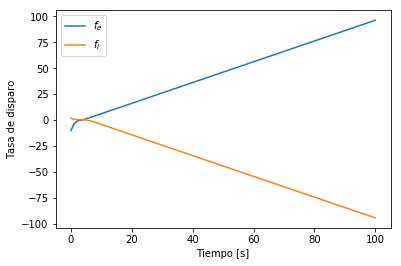

In [31]:
def heavy_side(f):
    if f > 0: return 1
    return 0
def S(f):
    return f*heavy_side(f)

# define the diferentia equations pair
def ode_function(y, t, I_e, I_i, g):
    fe = y[0]
    fi = y[1] 
    dfedt = - fe + g[0,0]*S(fe)- g[0,1]*S(fi) + I_e
    dfidt = - fi + g[1,0]*S(fe)- g[1,1]*S(fi) + I_i
    return np.array([dfedt,dfidt])
    
g = np.array([ [1,1],[-1,1]])
N = 100
t = np.linspace(0,100,N)
fe0 = -10
fi0 = 2
I_e = 1
I_i = 1
sol = odeint(ode_function, [fe0, fi0], t, args=(I_e, I_i, g) )
plt.plot(t,sol[:,0], '-',label=r'$f_{e}$')
plt.plot(t,sol[:,1], '-',label=r'$f_{i}$')
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Tasa de disparo")
plt.legend()
plt.show()

## Ejercicio 2

Simular la dinámica de dos neuronas HH conectadas simétricamente con interacciones sináticas excitatorias. 

In [32]:
#### define the differentia equations
def a_m(V):
    return 0.1 * (V + 40)/(1- exp(-(V+40)/10.0))
def b_m(V):
    return 4.0 * exp(- (V+65)/18)
def a_h(V):
    return 0.07 * exp(-(V + 65)/20)
def b_h(V):
    return 1/(1.0 + exp(-(V + 35)/10))
def a_n(V):
    return 0.01* (V + 55)/(1 - exp(-(V + 55)/10))
def b_n(V):
    return 0.125 *exp(-(V + 65)/80)
def m_inf(V):
    return a_m(V)/(a_m(V) + b_m(V))
def h_inf(V):
    return a_h(V)/(a_h(V) + b_h(V))
def n_inf(V):
    return a_n(V)/(a_n(V) + b_n(V))
def tau_m(V):
    return 1/(a_m(V) + b_m(V))
def tau_n(V):
    return 1/(a_n(V) + b_n(V))
def tau_h(V):
    return 1/(a_h(V) + b_h(V))

def s_inf(V):
    return  0.5*(1 + tanh(V/5))

In [5]:
C = 1;
V_na = 50;
V_k = -77;
V_l = -54.5;
g_na = 120;
g_k = 36;
g_l = 0.3;
g_syn = -1;

In [91]:
# define the differential equations
# Y =[V1, m1,h1,n1,S1,V2,m2,h2,n2,S2]

def pend(y, t,I_ext, V_syn, tau,g_syn):
    V1, m1,h1,n1,S1,V2,m2,h2,n2,S2 = y
    dV1dt = 1/C* (I_ext - g_na *m1**3 * h1*(V1- V_na) - g_k * n1**4 * (V1 - V_k) - g_l * (V1 - V_l) - g_syn*S2*(V1 - V_syn) )
    dV2dt = 1/C* (I_ext - g_na *m2**3 * h2*(V2- V_na) - g_k * n2**4 * (V2 - V_k) - g_l * (V2 - V_l)  - g_syn*S1*(V2 - V_syn))
    dm1dt =  (m_inf(V1) - m1)/tau_m(V1)
    dm2dt =  (m_inf(V2) - m2)/tau_m(V2)
    dn1dt =  (n_inf(V1) - n1)/tau_n(V1)
    dn2dt =  (n_inf(V2) - n2)/tau_n(V2)
    dh1dt =  (h_inf(V1) - h1)/tau_h(V1)
    dh2dt =  (h_inf(V2) - h2)/tau_h(V2)
    dS1dt = (s_inf(V1) - S1)/tau
    dS2dt = (s_inf(V2) - S2)/tau
    return [dV1dt, dm1dt, dh1dt, dn1dt, dS1dt,dV2dt, dm2dt, dh2dt, dn2dt, dS2dt]
 

In [88]:
def calcular_taza_disparo(times,spikes):
    assert times.size == spikes.size
    freq_val = fft.fft(spikes)
    sampling = times[1] - times[0]
    freq = fft.fftfreq(times.size, sampling)
    indexes = freq > 0.1
#     plt.xlim([0.11,1])
#     plt.plot(freq[indexes], np.abs(freq_val[indexes]),'-x')
    max_freq_pos = np.argmax(np.abs(freq_val[indexes]))
#     plt.show()
    max_freq = freq[indexes][max_freq_pos]
    print max_freq_pos, max_freq, 1/max_freq
    return max_freq

def find_zero_pos(signal, start):
    pos = start
    while signal[pos]*signal[pos-1] > 0:
        pos = pos + 1
    return pos

def calcular_desfasaje(time, signal1, signal2):

    signal1 = signal1 -  np.mean(signal1)
    signal2 = signal2 - np.mean(signal2)
    pos1 = find_zero_pos(signal1, 1)
    pos11 = find_zero_pos(signal1, pos1 + 1)
    
    pos2 = find_zero_pos(signal2, 1)
    pos22 = find_zero_pos(signal2, pos2 + 1)
    print "========"
    print    time[pos1] - time[pos2], time[pos11] - time[pos22] , time[pos1] - time[pos22]
    print "========"
    return time[pos1] - time[pos2]
    

#### Parte A

 Fijo $V_{syn} = 0$

In [99]:
I_ext = 100 # suficiente para que dispare
tau = 3

In [100]:

t = np.linspace(0,100,20000)

In [98]:

def run_simulation(V_syn):
    n = 20
    g_syn = np.linspace(0,4,n)
    plt.figure()
    indices = t > 30
    spikes = []
    tasas = []
    desfasajes = []
    t_indices = t > 21
    # V1, m1,h1,n1,S1,V2,m2,h2,n2,S2 
    y0 = [-10, 
          0,
          0,
          0,
          1,
          20,
          0,
          0,
          0,
          1]
    for i in range(0,n):
        print  "g_syn",g_syn[i]
        sol = odeint(pend, y0, t, args=(I_ext, V_syn,tau, g_syn[i]))
    #     plt.subplot(n, 1, i + 1)
    #     plt.xlim([20,40])
    #     plt.plot(t[t_indices], sol[t_indices, 0] - mean_value, 'b', label='V1(t)')
    #     plt.show()
    #     plt.plot(t[t_indices], sol[t_indices, 5] - mean_value , 'r', label='V2(t)')
    #     plt.show()
    #     plt.text(10,0,r"$g_{syn}$ = %lf"%g_syn[i])
        tasa = calcular_taza_disparo(t[indices],sol[indices,5])
        desfasaje = calcular_desfasaje(t[indices], sol[indices,0],sol[indices,5])
        print "desfasaje:",desfasaje
        tasas.append([g_syn[i],tasa])
        desfasajes.append([g_syn[i], desfasaje])
    data = np.array(tasas)
    plt.plot(data[:,0],1/data[:,1])
    plt.xlabel(r"$g_{syn}$")
    plt.ylabel(r"Tasa de disparo")
    plt.show()
    data= np.array(desfasajes)
    plt.plot(data[:,0],data[:,1],'x-')
    plt.xlabel(r"$g_{syn}$")
    plt.ylabel(r"$Desfasaje$")
    plt.show()



g_syn 0.0
2 0.14285 7.0003500175
0.335016750838 0.350017500875 -2.46012300615
desfasaje: 0.335016750838
g_syn 0.210526315789
2 0.14285 7.0003500175
0.30001500075 0.305015250763 -2.51012550628
desfasaje: 0.30001500075
g_syn 0.421052631579
2 0.14285 7.0003500175
0.250012500625 0.255012750638 -2.56512825641
desfasaje: 0.250012500625
g_syn 0.631578947368
2 0.14285 7.0003500175
0.2000100005 0.195009750488 -2.62013100655
desfasaje: 0.2000100005
g_syn 0.842105263158
2 0.14285 7.0003500175
0.145007250363 0.150007500375 -3.81519075954
desfasaje: 0.145007250363
g_syn 1.05263157895
2 0.14285 7.0003500175
0.115005750288 0.1200060003 -3.85519275964
desfasaje: 0.115005750288
g_syn 1.26315789474
2 0.14285 7.0003500175
0.090004500225 0.0950047502375 -3.89019450973
desfasaje: 0.090004500225
g_syn 1.47368421053
2 0.14285 7.0003500175
0.070003500175 0.0750037501875 -3.92519625981
desfasaje: 0.070003500175
g_syn 1.68421052632
2 0.14285 7.0003500175
0.06000300015 0.0650032501625 -3.95019750988
desfasaje: 0

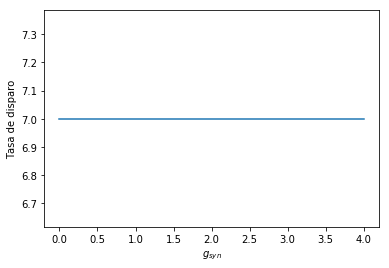

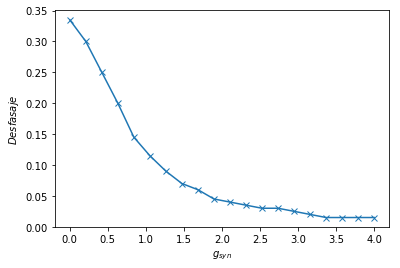

In [101]:
run_simulation(0)

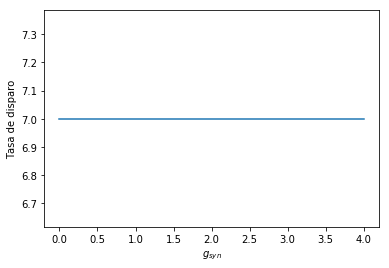

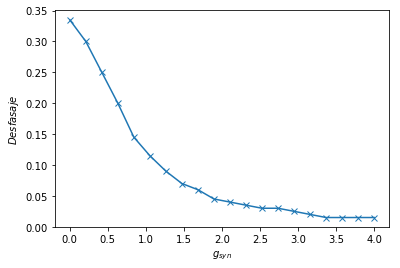

### Parte B

Fijo $V_{syn} =  -80$

g_syn 0.0
2 0.14285 7.0003500175
0.335016750838 0.350017500875 -2.46012300615
desfasaje: 0.335016750838
g_syn 0.210526315789
2 0.14285 7.0003500175
0.390019500975 0.395019750988 -2.41512075604
desfasaje: 0.390019500975
g_syn 0.421052631579
2 0.14285 7.0003500175
0.425021251063 0.435021751088 -2.38011900595
desfasaje: 0.425021251063
g_syn 0.631578947368
2 0.14285 7.0003500175
0.435021751088 0.4400220011 -2.37511875594
desfasaje: 0.435021751088
g_syn 0.842105263158
2 0.14285 7.0003500175
0.42002100105 0.42002100105 -2.39511975599
desfasaje: 0.42002100105
g_syn 1.05263157895
2 0.14285 7.0003500175
0.400020001 0.390019500975 -2.42012100605
desfasaje: 0.400020001
g_syn 1.26315789474
2 0.14285 7.0003500175
-3.61018050903 -2.45512275614 -6.42532126606
desfasaje: -3.61018050903
g_syn 1.47368421053
2 0.14285 7.0003500175
-3.67018350918 -2.51012550628 -6.48532426621
desfasaje: -3.67018350918
g_syn 1.68421052632
2 0.14285 7.0003500175
0.2400120006 0.250012500625 -3.72518625931
desfasaje: 0.240012

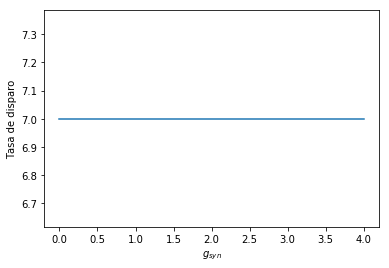

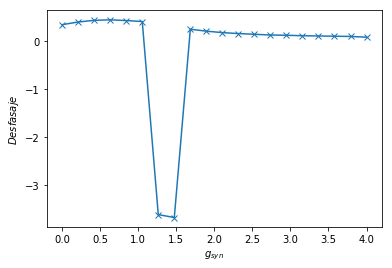

In [102]:
V_syn =  -80
run_simulation(V_syn)